## Mask R-CNN Instance Segmentation

Mask people that are present in an image

In [17]:
# Import the relevant dataset and training utilities
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar
!rm images.tar annotations_instance.tar
!pip install -qU torch_snippets
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_utils.py
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [18]:
# Import the necessary packages and define device
from torch_snippets import *
from torch_snippets.inspector import inspect
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
# Fetch images that contain masks of people
# Loop through the images and annotations_instance folders to fetch filenames
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

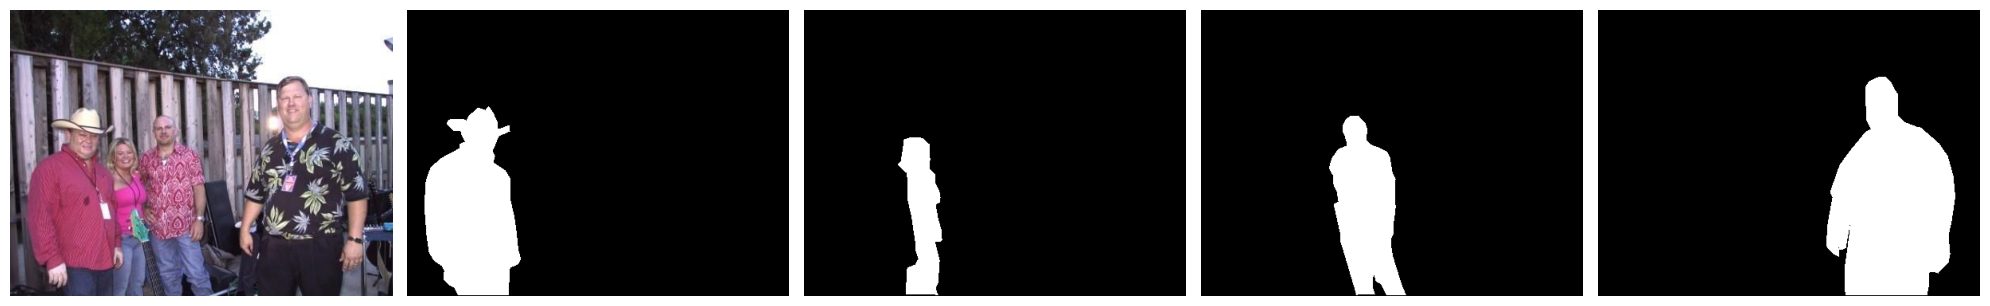

In [20]:
# Inspect the original image and the representation of masks of instances of people
f = 'ADE_train_00014301'

im = read(find(f, all_images), 1)
an = read(find(f, all_annots), 1).transpose(2,0,1)
r,g,b = an
nzs = np.nonzero(r==4) # 4 stands for person
instances = np.unique(g[nzs])
masks = np.zeros((len(instances), *r.shape))
for ix,_id in enumerate(instances):
    masks[ix] = g==_id

subplots([im, *masks], sz=20)

In [21]:
# Loop through the annotations and store the files containingat least one person
annots = []
for ann in Tqdm(all_annots[:5000]):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if 4 not in np.unique(r): continue
    annots.append(ann)

100%|██████████| 5000/5000 [00:13<00:00, 374.55it/s]


In [22]:
# Split the files into training and validation files
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

In [23]:
# Define the transformation method
def get_transform(train):
    image_transforms = []
    image_transforms.append(T.PILToTensor())
    if train:
        image_transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(image_transforms)

In [24]:
# Create the dataset class
class MasksDataset(Dataset):
    # Takes in image names, transformation method, and number of files to consider
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
    # Fetches a number of masks that is equivalent to the instances present in the image
    def get_mask(self, path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        nzs = np.nonzero(r==4)
        instances = np.unique(g[nzs])
        masks = np.zeros((len(instances), *r.shape))
        for ix,_id in enumerate(instances):
            masks[ix] = g==_id
        return masks
    # Fetch an image and corresponding target values to be returned 
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks = self.get_mask(mask_path)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        # Bounding box information
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        # Convert target values into tensor objects
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        # Store the target values in a dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        # Specify the transformation method and return the target image
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if (img.dtype == torch.float32) or (img.dtype == torch.uint8) :
          img = img/255.
        return img, target
    # Specify the length method 
    def __len__(self):
        return self.N
    # Define the function that will choose a random image
    def choose(self):
        return self[randint(len(self))]

══════════════════════════════════════════════════════════════════

tensor([[[0.0745, 0.0588, 0.1176,  ..., 0.5843, 0.5725, 0.5608],
         [0.0863, 0.0706, 0.1451,  ..., 0.5529, 0.5725, 0.5882],
         [0.0784, 0.0745, 0.1686,  ..., 0.5529, 0.5922, 0.6353],
         ...,
         [0.0667, 0.0667, 0.0667,  ..., 0.1451, 0.1412, 0.1373],
         [0.0667, 0.0667, 0.0667,  ..., 0.1529, 0.1490, 0.1451],
         [0.0667, 0.0667, 0.0667,  ..., 0.1569, 0.1569, 0.1529]],

        [[0.0627, 0.0510, 0.1020,  ..., 0.4235, 0.4118, 0.4000],
         [0.0745, 0.0627, 0.1294,  ..., 0.3922, 0.4118, 0.4275],
         [0.0667, 0.0667, 0.1529,  ..., 0.3922, 0.4314, 0.4745],
         ...,
         [0.0549, 0.0549, 0.0510,  ..., 0.1294, 0.1255, 0.1216],
         [0.0549, 0.0549, 0.0510,  ..., 0.1373, 0.1333, 0.1294],
         [0.0549, 0.0549, 0.0510,  ..., 0.1412, 0.1412, 0.1373]],

        [[0.0980, 0.0706, 0.0902,  ..., 0.1647, 0.1529, 0.1412],
         [0.1098, 0.0824, 0.1176,  ..., 0.1333, 0.1529, 0.1686],
         [0.0941, 0.0784, 0.1412,  ..., 0.1333, 0.1725, 0.2157],
         ...,
         [0.0980, 0.0980, 0.1059,  ..., 0.0941, 0.0902, 0.0863],
         [0.0980, 0.0980, 0.1059,  ..., 0.1020, 0.0980, 0.0941],
         [0.0980, 0.0980, 0.1059,  ..., 0.1059, 0.1059, 0.1020]]])

══════════════════════════════════════════════════════════════════

dict of 6 items

tensor([[259., 277., 284., 299.],
        [194., 283., 222., 316.]])

tensor([1, 1])

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

tensor([0])

tensor([550., 924.])

... ... 1 more item(s)

══════════════════════════════════════════════════════════════════

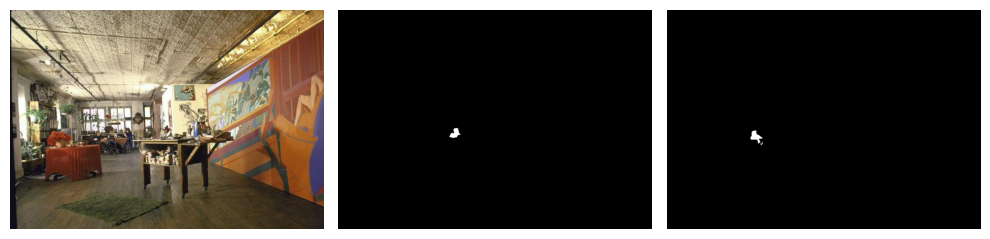

In [25]:
# Inspect an input/output combination
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[0]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)

In [26]:
# Define the instance segmantation model
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [27]:
model = get_model_instance_segmentation(2).to(device)
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [28]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=len(trn_items))
dataset_test = MasksDataset(val_items, get_transform(train=False), N=len(val_items))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [29]:
num_classes = 2
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [45]:
#!pip install scikit-learn --upgrade --user
#!pip uninstall numpy
!pip install "numpy<1.20"



Found existing installation: numpy 1.19.5
Uninstalling numpy-1.19.5:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.8
    /usr/local/lib/python3.8/dist-packages/numpy-1.19.5.dist-info/*
    /usr/local/lib/python3.8/dist-packages/numpy.libs/libgfortran-2e0d59d6.so.5.0.0
    /usr/local/lib/python3.8/dist-packages/numpy.libs/libopenblasp-r0-09e95953.3.13.so
    /usr/local/lib/python3.8/dist-packages/numpy.libs/libquadmath-2d0c479f.so.0.0.0
    /usr/local/lib/python3.8/dist-packages/numpy.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.8/dist-packages/numpy/*
Proceed (y/n)? ^C
ERROR: Operation cancelled by user


In [50]:
import sys
sys.path.insert(0,"/usr/local/lib/python3.8/dist-packages/numpy-1.19.5.dist-info/")

In [53]:
import numpy as np
np.__version__


# monkey patch -real term
# LINK: https://stackoverflow.com/questions/74844262/how-can-i-solve-error-module-numpy-has-no-attribute-float-in-python
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool 


In [59]:
num_epochs = 100

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=468) # changed to 468
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset 
    res = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/468]  eta: 0:02:46  lr: 0.000000  loss: 0.5244 (0.5244)  loss_classifier: 0.0897 (0.0897)  loss_box_reg: 0.1497 (0.1497)  loss_mask: 0.2501 (0.2501)  loss_objectness: 0.0316 (0.0316)  loss_rpn_box_reg: 0.0032 (0.0032)  time: 0.3558  data: 0.0195  max mem: 4747
Epoch: [0]  [467/468]  eta: 0:00:00  lr: 0.000000  loss: 0.5654 (0.5695)  loss_classifier: 0.0915 (0.0930)  loss_box_reg: 0.1319 (0.1528)  loss_mask: 0.2997 (0.2939)  loss_objectness: 0.0078 (0.0130)  loss_rpn_box_reg: 0.0077 (0.0167)  time: 0.3971  data: 0.0245  max mem: 4747
Epoch: [0] Total time: 0:03:00 (0.3851 s / it)
creating index...
index created!
Test:  [  0/313]  eta: 0:00:30  model_time: 0.0832 (0.0832)  evaluator_time: 0.0075 (0.0075)  time: 0.0986  data: 0.0075  max mem: 4747
Test:  [100/313]  eta: 0:00:25  model_time: 0.0783 (0.0881)  evaluator_time: 0.0059 (0.0181)  time: 0.1041  data: 0.0094  max mem: 4747
Test:  [200/313]  eta: 0:00:13  model_time: 0.0763 (0.0869)  evaluator_time: 0.0058 (0.0165)

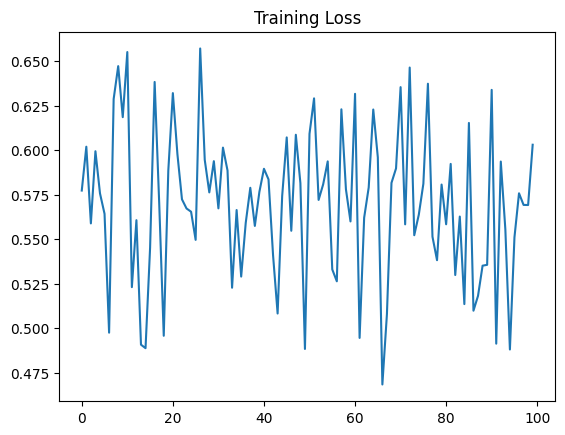

In [60]:
import matplotlib.pyplot as plt
plt.title('Training Loss') 
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

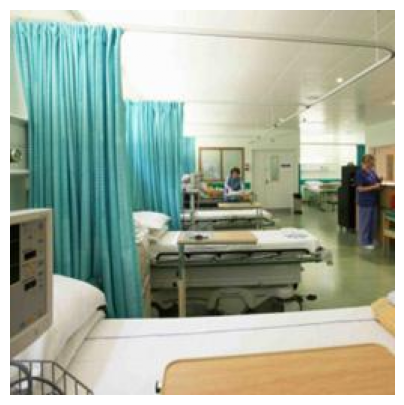

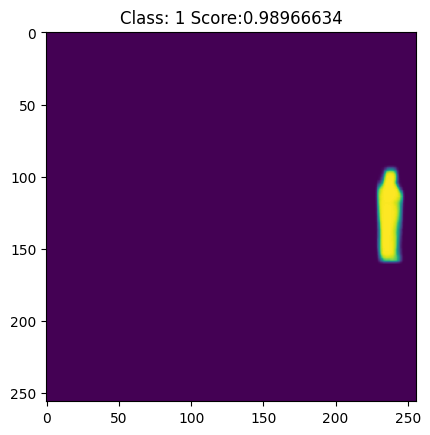

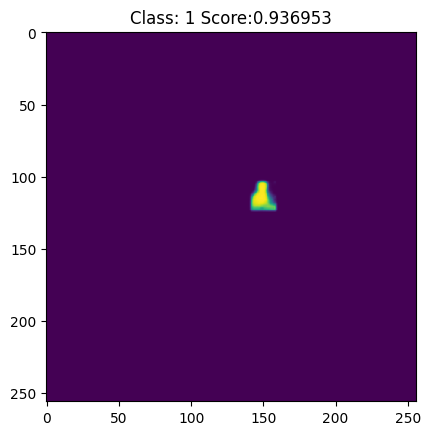

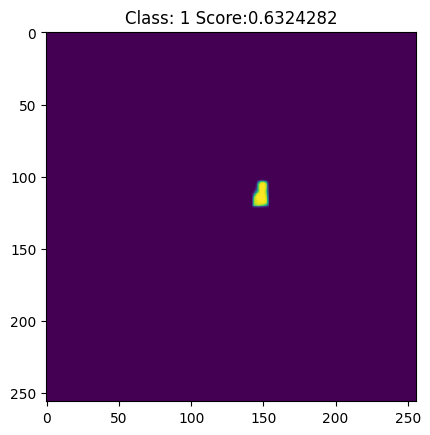

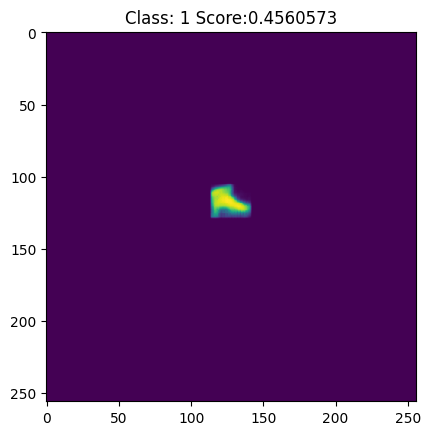

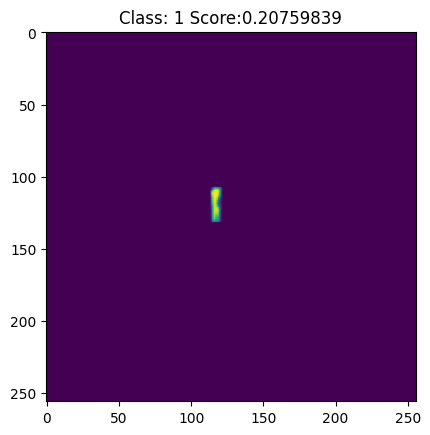

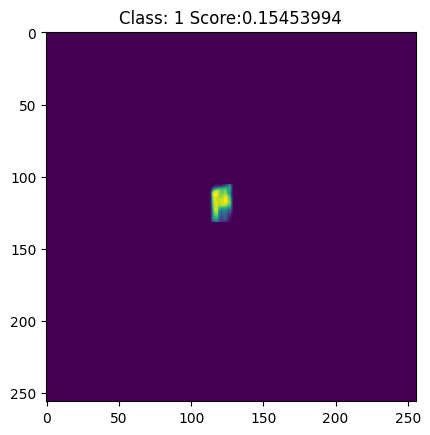

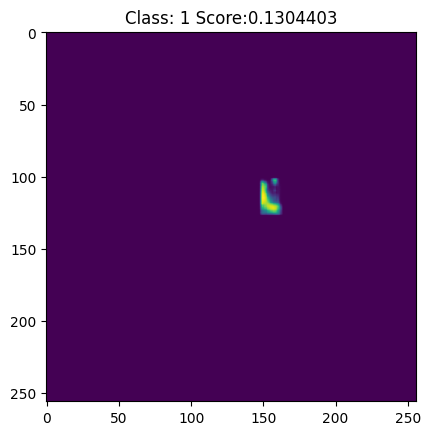

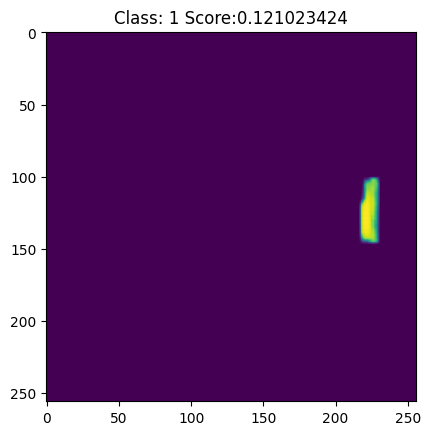

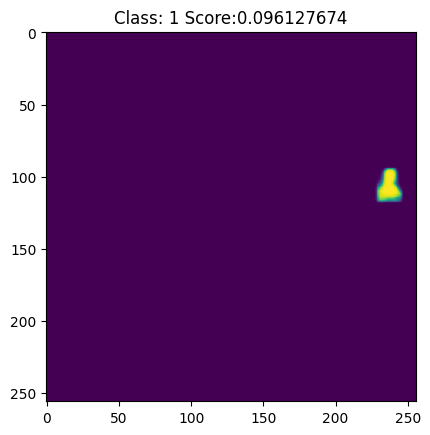

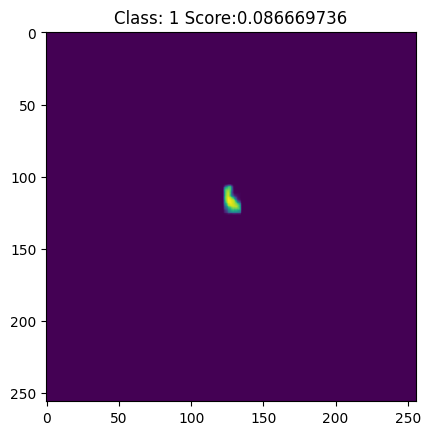

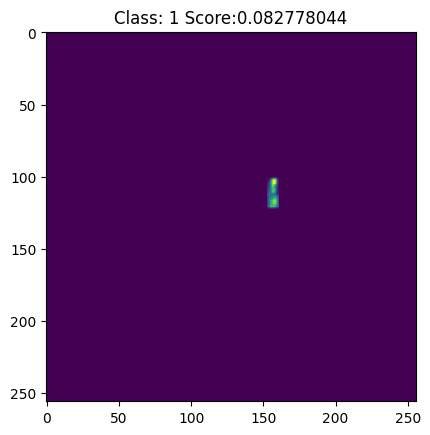

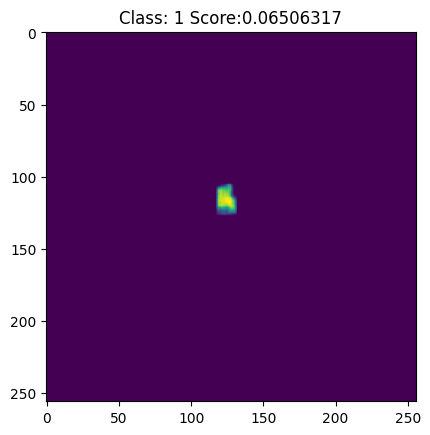

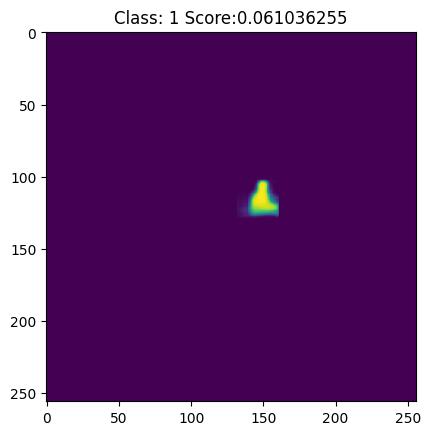

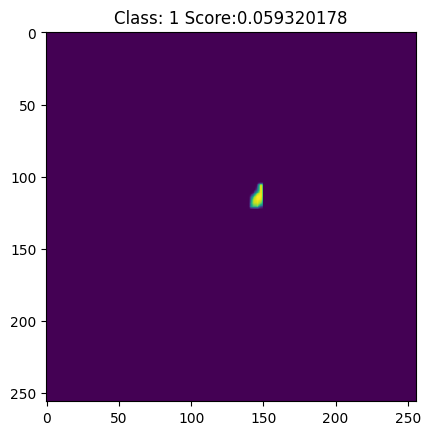

In [58]:
model.eval()
im = dataset_test[10][0]
show(im)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()